In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import re
import csv

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam


In [ ]:
!pip install transformers

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [ ]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("law-ai/InLegalBert")
bert_model = AutoModel.from_pretrained("law-ai/InLegalBert",output_hidden_states=True)
# bert_model = bert_model.to('cuda')

from transformers import AutoTokenizer, AutoModelForPreTraining

# tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")
# bert_model = AutoModelForPreTraining.from_pretrained("nlpaueb/legal-bert-base-uncased")
# bert_model = bert_model.to('cuda')

In [ ]:
f = open("/content/drive/MyDrive/LegalNERDatasets/NER_TRAIN/NER_TRAIN_JUDGEMENT.json")

data = json.load(f)
print("Total training samples provided by the organizers: ", len(data))

AllText=[]
for i in range(len(data)):
    TempText=[]
    if len(data[i]['annotations'][0]['result'])!=0:

        for j in range(len(data[i]['annotations'][0]['result'])):
            TempText.append(data[i]['annotations'][0]['result'][j]['value']['text'])
        AllText.append(TempText)


CleanedText=[]
for i in range(len(AllText)):
    TempCleanedText=[]
    for j in range(len(AllText[i])):
        AllText[i][j]=AllText[i][j].replace("\n"," ")
        AllText[i][j]=re.sub('\s+',' ',AllText[i][j])
        AllText[i][j]=AllText[i][j].lower()
        TempCleanedText.append(AllText[i][j])
    CleanedText.append(TempCleanedText)
print("After cleaning, total number of samples in training data (documentwise): ", len(CleanedText))

AllLabels=[]
for i in range(len(data)):
    TempLabels=[]
    if len(data[i]['annotations'][0]['result'])!=0:
        for j in range(len(data[i]['annotations'][0]['result'])):
            TempLabels.append(data[i]['annotations'][0]['result'][j]['value']['labels'][0])
        AllLabels.append(TempLabels)

for i in range(len(AllLabels)):
    for j in range(len(AllLabels[i])):
        AllLabels[i][j]=AllLabels[i][j].lower()
print("After cleaning, total number of labels in training data (documentwise): ", len(AllLabels))

SentwiseCleanedText=[]
for i in range(len(CleanedText)):
  for j in range(len(CleanedText[i])):
      SentwiseCleanedText.append(CleanedText[i][j])

SentwiseLabels=[]
for i in range(len(AllLabels)):
  for j in range(len(AllLabels[i])):
      SentwiseLabels.append(AllLabels[i][j])

print("Total number of sentences in training data: ", len(SentwiseCleanedText))
print("Total number of labels in the training data: ", len(SentwiseLabels))

Total training samples provided by the organizers:  9435
After cleaning, total number of samples in training data (documentwise):  7258
After cleaning, total number of labels in training data (documentwise):  7258
Total number of sentences in training data:  17485
Total number of labels in the training data:  17485


In [ ]:
f = open("/content/drive/MyDrive/LegalNERDatasets/NER_DEV/NER_DEV_JUDGEMENT.json")

val_data = json.load(f)
print("Total validation samples provided by the organizers: ", len(val_data))

DevText=[]
for i in range(len(val_data)):
    TempText=[]
    for j in range(len(val_data[i]['annotations'][0]['result'])):
        TempText.append(val_data[i]['annotations'][0]['result'][j]['value']['text'])
    DevText.append(TempText)


CleanedDevText=[]
for i in range(len(DevText)):
    TempCleanedText=[]
    for j in range(len(DevText[i])):
        DevText[i][j]=DevText[i][j].replace("\n"," ")
        DevText[i][j]=re.sub('\s+',' ',DevText[i][j])
        DevText[i][j]=DevText[i][j].lower()
        TempCleanedText.append(DevText[i][j])
    CleanedDevText.append(TempCleanedText)

AllDevLabels=[]
for i in range(len(val_data)):
    TempLabels=[]
    for j in range(len(val_data[i]['annotations'][0]['result'])):
        TempLabels.append(val_data[i]['annotations'][0]['result'][j]['value']['labels'][0])
    AllDevLabels.append(TempLabels)

for i in range(len(AllDevLabels)):
    for j in range(len(AllDevLabels[i])):
        AllDevLabels[i][j]=AllDevLabels[i][j].lower()

print("After cleaning, total number of samples in validation data (documentwise): ", len(CleanedDevText))
print("After cleaning, total number of labels in validation data (documentwise): ", len(AllDevLabels))

SentwiseCleanedDevText=[]
for i in range(len(CleanedDevText)):
  for j in range(len(CleanedDevText[i])):
      SentwiseCleanedDevText.append(CleanedDevText[i][j])

SentwiseDevLabels=[]
for i in range(len(AllDevLabels)):
  for j in range(len(AllDevLabels[i])):
      SentwiseDevLabels.append(AllDevLabels[i][j])

print("Total number of sentences in Validation data: ", len(SentwiseCleanedDevText))
print("Total number of labels in validation data: ", len(SentwiseDevLabels))

Total validation samples provided by the organizers:  949
After cleaning, total number of samples in validation data (documentwise):  949
After cleaning, total number of labels in validation data (documentwise):  949
Total number of sentences in Validation data:  1876
Total number of labels in validation data:  1876


In [ ]:
f = open("/content/drive/MyDrive/LegalNERDatasets/NER_TEST/NER_TEST_JUDGEMENT.json")

Test_data = json.load(f)
print("Total Test samples provided by the organizers: ", len(Test_data))

TestText=[]
for i in range(len(Test_data)):
    TempText=[]
    for j in range(len(Test_data[i]['annotations'][0]['result'])):
        TempText.append(Test_data[i]['annotations'][0]['result'][j]['value']['text'])
    TestText.append(TempText)


CleanedTestText=[]
for i in range(len(TestText)):
    TempCleanedText=[]
    for j in range(len(TestText[i])):
        TestText[i][j]=TestText[i][j].replace("\n"," ")
        TestText[i][j]=re.sub('\s+',' ',TestText[i][j])
        TestText[i][j]=TestText[i][j].lower()
        TempCleanedText.append(TestText[i][j])
    CleanedTestText.append(TempCleanedText)

AllTestLabels=[]
for i in range(len(Test_data)):
    TempLabels=[]
    for j in range(len(Test_data[i]['annotations'][0]['result'])):
        TempLabels.append(Test_data[i]['annotations'][0]['result'][j]['value']['labels'][0])
    AllTestLabels.append(TempLabels)

for i in range(len(AllTestLabels)):
    for j in range(len(AllTestLabels[i])):
        AllTestLabels[i][j]=AllTestLabels[i][j].lower()

print("After cleaning, total number of samples in test data (documentwise): ", len(CleanedTestText))
print("After cleaning, total number of labels in test data (documentwise): ", len(AllTestLabels))

SentwiseCleanedTestText=[]
for i in range(len(CleanedTestText)):
  for j in range(len(CleanedTestText[i])):
      SentwiseCleanedTestText.append(CleanedTestText[i][j])

SentwiseTestLabels=[]
for i in range(len(AllTestLabels)):
  for j in range(len(AllTestLabels[i])):
      SentwiseTestLabels.append(AllTestLabels[i][j])

print("Total number of sentences in test data: ", len(SentwiseCleanedTestText))
print("Total number of labels in test data: ", len(SentwiseTestLabels))

Total Test samples provided by the organizers:  4060
After cleaning, total number of samples in test data (documentwise):  4060
After cleaning, total number of labels in test data (documentwise):  4060
Total number of sentences in test data:  8718
Total number of labels in test data:  8718


In [ ]:
encoded_labels=[]
from sklearn.preprocessing import LabelEncoder

label_enc= LabelEncoder()
label_enc.fit(SentwiseLabels)

y_tr=label_enc.transform(SentwiseLabels)
y_val=LabelEncoder().fit_transform(SentwiseDevLabels)
y_test=LabelEncoder().fit_transform(SentwiseTestLabels)

In [ ]:
def numpyarray(sent):
  # print('o')
  granola_ids = tokenizer.encode(sent, max_length=1000)
  granola_ids = torch.LongTensor(granola_ids)
  granola_ids = granola_ids.to(device)
  # print(granola_ids.shape)
  bert_model.eval()
  # print('o')
  granola_ids = granola_ids.unsqueeze(0)
  # print(granola_ids.shape)
  with torch.no_grad():
    out = bert_model(input_ids=granola_ids)
    # print(out[1].shape)
  hidden_states = out[2]
  sentence_embedding = torch.mean(hidden_states[-1], dim=1).squeeze()
  # print(sentence_embedding.shape)
  np_tensor = sentence_embedding.cpu().numpy()
  return np_tensor

With the help of code given below, we are creating numerical vector of each sentence of a document. This block of code needs to be run for once. Once we have csv file containing the numerical vectors along with their labels, we can utilize this while training.

In [ ]:
import csv
import numpy as np
for j in range(len(SentwiseCleanedText)):

	if j%1000==0:
		print(j)
	with open('/content/drive/MyDrive/LegalNERDatasets/NER_TRAIN/train_embeddings_LB.csv', 'a+', newline='',encoding='utf-8') as write_obj:
		# Create a writer object from csv module
		csv_writer = csv.writer(write_obj, quoting= csv.QUOTE_NONNUMERIC)
		# Add contents of list as last row in the csv file
		csv_writer.writerow(np.append(numpyarray(SentwiseCleanedText[j]),[SentwiseLabels[j]]))

	write_obj.close()

for j in range(len(SentwiseCleanedDevText)):

	if j%1000==0:
		print(j)
	with open('/content/drive/MyDrive/LegalNERDatasets/NER_DEV/val_embeddings_LB.csv', 'a+', newline='',encoding='utf-8') as write_obj:
		# Create a writer object from csv module
		csv_writer = csv.writer(write_obj, quoting= csv.QUOTE_NONNUMERIC)
		# Add contents of list as last row in the csv file
		csv_writer.writerow(np.append(numpyarray(SentwiseCleanedDevText[j]),[SentwiseDevLabels[j]]))

	write_obj.close()

for j in range(len(SentwiseCleanedTestText)):

	if j%1000==0:
		print(j)
	with open('/content/drive/MyDrive/LegalNERDatasets/NER_TEST/test_embeddings_LB.csv', 'a+', newline='',encoding='utf-8') as write_obj:
		# Create a writer object from csv module
		csv_writer = csv.writer(write_obj, quoting= csv.QUOTE_NONNUMERIC)
		# Add contents of list as last row in the csv file
		csv_writer.writerow(np.append(numpyarray(SentwiseCleanedTestText[j]),[SentwiseTestLabels[j]]))

	write_obj.close()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
0
1000
0
1000
2000
3000
4000


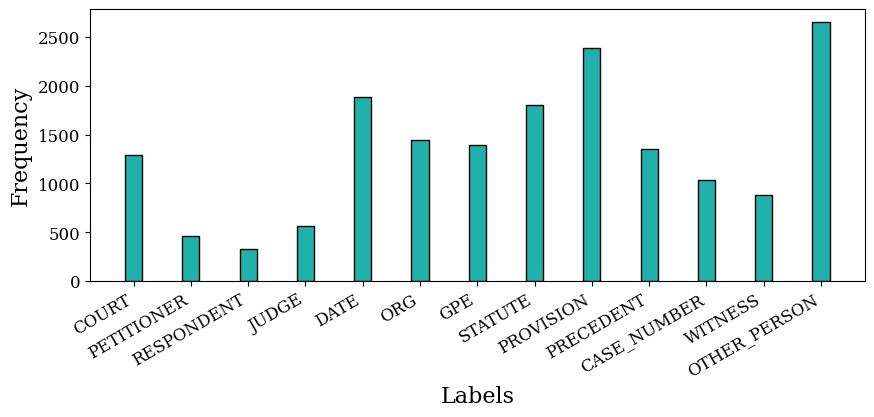

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data={'COURT':1293,'PETITIONER':464 ,'RESPONDENT':324,'JUDGE':567,'DATE':1885, 'ORG':1441, 'GPE':1398,
'STATUTE':1804, 'PROVISION':2384,'PRECEDENT':1351, 'CASE_NUMBER':1040, 'WITNESS':881, 'OTHER_PERSON':2653}

# data = {'Baseline': 0.6160, 'Model1':0.7419, 'Model2':0.725,'Model3':0.7368, 'Model4':0.7201}
labels = list(data.keys())
freqs = list(data.values())

fig = plt.figure(figsize = (10,4))

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
# plt.rcParams.update({'font.family':'DejaVu Serif'})
# creating the bar plot
plt.bar(labels, freqs, color ='#20B2AA',edgecolor= 'black', width = 0.3)

plt.xlabel("Labels", fontsize=16)
plt.ylabel("Frequency",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.ylim(ymin=150,ymax=10900)
fig.autofmt_xdate()

plt.show()

# plt.title("Students enrolled in different courses")
# plt.savefig('Freq.eps', format='eps',bbox_inches='tight')

In [ ]:
# label_dict= {0: 'CASE_NUMBER', 1: 'COURT', 2:'DATE', 3: 'GPE',
#              4: 'JUDGE',5:'ORG',6:'OTHER_PERSON',7: 'PETITIONER', 8:'PRECEDENT',
#              9:'PROVISION', 10: 'RESPONDENT', 11: 'STATUTE', 12: 'WITNESS'}

The code below gives the weight to each of the class. One can utilize this to somehow deal with the problem of class imbalance. In our baseline model, we did not use it because we did not observe much improvement.

In [ ]:
import numpy as np
import math

# labels_dict : {ind_label: count_label}
# mu : parameter to tune

def create_class_weight(labels_dict,mu=0.72):
    total = np.sum(list(labels_dict.values()))
    print(total)
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]+1))
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

# random labels_dict
labels_dict = {0 :1040, 1 :1293 , 2 :1885, 3 :1398 , 4 :567 , 5 :1441, 6 :2653, 7 :464,
8 :1351, 9 :2384, 10 :1351, 11 :324, 12 :1804, 13 :881}

class_weights=create_class_weight(labels_dict)
print(class_weights)

17485
{0: 2.2751011074645944, 1: 3.298557176938084, 2: 3.6567694001957025, 3: 3.0984731638042886, 4: 9.44059458252544, 5: 1.8983811193320372, 6: 2.1668082646805455, 7: 2.1970816078599587, 8: 1.9422787117584588, 9: 1.6636401792029984, 10: 2.2312543259225306, 11: 2.4926575139104714, 12: 2.658402526518649, 13: 1.5567713676332873}


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/LegalNERDatasets/NER_TRAIN/train_embeddings_ILB.csv',header=None)
# Y = df[768].tolist()
df.drop(768, axis=1, inplace=True)
df=df.values.tolist()

In [ ]:
df_val=pd.read_csv('/content/drive/MyDrive/LegalNERDatasets/NER_DEV/val_embeddings_ILB.csv',header=None)
# Y_val = df_val[768].tolist()
df_val.drop(768, axis=1, inplace=True)
df_val=df_val.values.tolist()

In [ ]:
df_test=pd.read_csv('/content/drive/MyDrive/LegalNERDatasets/NER_TEST/test_embeddings_ILB.csv',header=None)
# Y_test = df_test[768].tolist()
df_test.drop(768, axis=1, inplace=True)
df_test=df_test.values.tolist()

In [ ]:
df=np.asarray(df)
df_val=np.asarray(df_val)
df_test=np.asarray(df_test)
print(df.shape)
print(df_val.shape)
print(df_test.shape)
print(y_tr.shape)
print(y_val.shape)
print(y_test.shape)


(17485, 768)
(1876, 768)
(8718, 768)
(17485,)
(1876,)
(8718,)


*Multi-layer perceptron (MLP) model utilize for training*

In [ ]:
inputA= Input(shape=(df.shape[1],))
x=  Dense(2048, activation="relu")(inputA)
x=Dropout(0.6)(x)
x=Dense(1024,activation="relu")(x)
x=Dropout(0.6)(x)
x=Dense(units=13, activation='softmax')(x)
model= Model(input=inputA,output=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), loss="sparse_categorical_crossentropy", metrics = ['accuracy'])
model.summary()

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, restore_best_weights=True)
history=model.fit(df, y_tr, validation_data=(df_val,y_val),epochs =5,callbacks=[es], batch_size= 32, class_weight=class_weights)

In [ ]:
model.save('/content/drive/My Drive/BertModels/CustomInLawBert.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import keras
model=keras.models.load_model('/content/drive/My Drive/BertModels/CaseInLawBert.h5')

In [ ]:
y_prob=model.predict(df_test)
flat_pred=np.argmax(y_prob,axis=1)
flat_pred.shape

273/273 [==============================] - 6s 21ms/step


(8718,)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print('Classification Report:')
print(classification_report(flat_pred, y_test, digits=4))
from sklearn import metrics
print(metrics.accuracy_score(y_test, flat_pred))

Classification Report:
              precision    recall  f1-score   support

           0     0.9865    0.9880    0.9872       666
           1     0.9625    0.9784    0.9703       786
           2     0.9973    0.9982    0.9978      1111
           3     0.7698    0.9039    0.8315       614
           4     0.2381    0.1515    0.1852        66
           5     0.8031    0.9315    0.8625       788
           6     0.8593    0.5589    0.6773      1705
           7     0.0000    0.0000    0.0000        10
           8     0.9846    0.9682    0.9764       661
           9     0.9959    0.9975    0.9967      1218
          10     0.0000    0.0000    0.0000         4
          11     0.9774    0.9754    0.9764       977
          12     0.0823    0.3036    0.1295       112

    accuracy                         0.8752      8718
   macro avg     0.6659    0.6735    0.6608      8718
weighted avg     0.9103    0.8752    0.8848      8718

0.8752007341133288


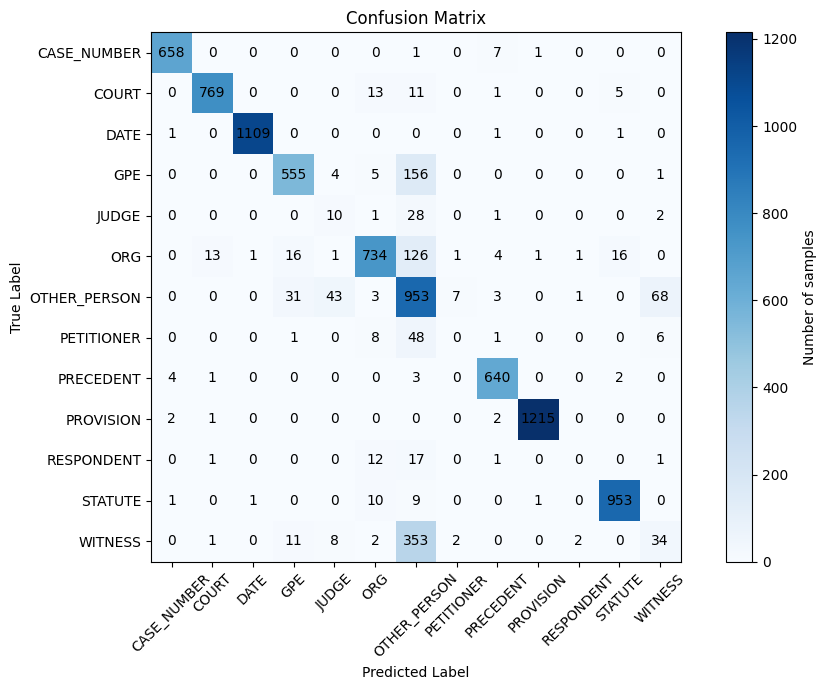

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assuming you have your true labels (y_true) and predicted labels (y_pred)

# Create the confusion matrix
cm = confusion_matrix(y_test, flat_pred)
label_dict= ['CASE_NUMBER', 'COURT', 'DATE', 'GPE',
             'JUDGE','ORG','OTHER_PERSON','PETITIONER', 'PRECEDENT',
             'PROVISION', 'RESPONDENT', 'STATUTE', 'WITNESS']
# Normalize the confusion matrix (optional)
# This displays the percentage of true labels for each predicted class
# cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
plt.imshow(cm, cmap='Blues')  # You can choose other colormaps like 'Greens' or 'YlOrBr'
plt.colorbar(label='Number of samples')

# Print class labels on x and y axes
class_names = [label_dict[i] for i in range(len(cm))]  # Assuming your classes are numbered 0 to len(cm)-1
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)

# Plot formatting
plt.grid(False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Print values inside the confusion matrix cells
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

print(precision_score(y_val,flat_pred, average='weighted'))
print(recall_score(y_val,flat_pred, average='weighted'))
print(f1_score(y_val,flat_pred, average='weighted'))

print(precision_score(y_val,flat_pred, average='micro'))
print(recall_score(y_val,flat_pred, average='micro'))
print(f1_score(y_val,flat_pred, average='micro'))

print(precision_score(y_val,flat_pred, average='macro'))
print(recall_score(y_val,flat_pred, average='macro'))
print(f1_score(y_val,flat_pred, average='macro'))


During testing phase, we utilized the code written below in order to make a submission.

In [ ]:
#For creating the document wise embeddings.
def bert_embeds(doc):

  np_tensor=[]
  for i in range(len(doc)):

    granola_ids = tokenizer.encode(doc[i], max_length=100)
    granola_ids = torch.LongTensor(granola_ids)
    granola_ids = granola_ids.to(device)
    bert_model.eval()
    granola_ids = granola_ids.unsqueeze(0)
    with torch.no_grad():
      out = bert_model(input_ids=granola_ids)
    hidden_states = out[2]
    sentence_embedding = torch.mean(hidden_states[-1], dim=1).squeeze()
    np_tensor.append(sentence_embedding.cpu().numpy())
  return np_tensor

In [ ]:

import re
from sklearn.metrics import precision_recall_fscore_support
def pred_probs(doc):
    bert_embedding=bert_embeds(doc)
#     print(bert_embedding[0].shape)
    y_prob=model.predict(np.asarray(bert_embedding))
    flat_pred=np.argmax(y_prob,axis=1).flatten()
    flat_pred_list= flat_pred.tolist()
    # label_list=[]
    # for key in flat_pred_list:
    #     label_list.append(label_dict[key])
    y_pred_string =label_enc.inverse_transform(flat_pred)
    label= y_pred_string.tolist()

# print(label)

    return label



In [ ]:
# total_prob=[]
# for i in range(10):
#     print(i)
#     print(CleanedTestText[i])
#     total_prob.append(pred_probs(CleanedTestText[i]))
pred_probs(['Constitution Bench'])

1/1 [==============================] - 0s 34ms/step


['court']